In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness = 0.5198986975397974
Generation = 2
Fitness = 0.5235166425470333
Generation = 3
Fitness = 0.5235166425470333
Generation = 4
Fitness = 0.5256874095513748
Generation = 5
Fitness = 0.5296671490593343
Generation = 6
Fitness = 0.5307525325615051
Generation = 7
Fitness = 0.5307525325615051
Generation = 8
Fitness = 0.5332850940665702
Generation = 9
Fitness = 0.5336468885672938
Generation = 10
Fitness = 0.5369030390738061
Generation = 11
Fitness = 0.5390738060781476
Generation = 12
Fitness = 0.5390738060781476
Generation = 13
Fitness = 0.5455861070911722
Generation = 14
Fitness = 0.5455861070911722
Generation = 15
Fitness = 0.5502894356005789
Generation = 16
Fitness = 0.557163531114327
Generation = 17
Fitness = 0.557163531114327
Generation = 18
Fitness = 0.557163531114327
Generation = 19
Fitness = 0.5600578871201157
Generation = 20
Fitness = 0.5691027496382055
Generation = 21
Fitness = 0.5691027496382055
Generation = 22
Fitness = 0.5691027496382055
Generation = 23
Fitnes

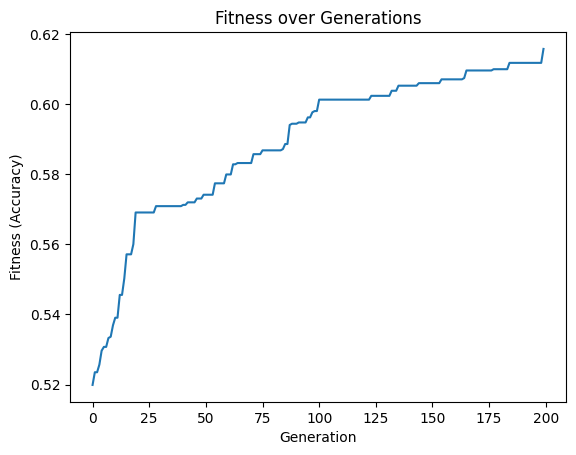

Test Accuracy: 0.48625180897250364


In [2]:
import pandas as pd
import numpy as np
import pygad
import pygad.nn
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
file_path = '/content/sample_data/advanced_synthetic_accident_data.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Preprocess the dataset (encoding categorical variables and scaling numerical ones)
df = df.select_dtypes(exclude=['datetime'])  # Remove datetime columns
df = pd.get_dummies(df, drop_first=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Split dataset into features and labels (example target: whether an accident is fraudulent or not)
X = scaled_features
y = np.random.randint(0, 2, X.shape[0])  # Placeholder: Replace with actual labels indicating fraud

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to GPU tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Genetic Algorithm Parameters
sol_per_pop = 50  # Number of solutions in the population
num_generations = 200  # Number of generations
num_parents_mating = 20  # Number of parents to mate in each generation
mutation_percent_genes = 10  # Percentage of genes to mutate
elitism_size = 5  # Number of elite individuals to retain

# Create fitness function
def fitness_function(ga_instance, solution, solution_idx):
    hidden_layer1_weights = torch.tensor(solution[:input_neurons * 8].reshape(input_neurons, 8), dtype=torch.float32).to(device)
    hidden_layer2_weights = torch.tensor(solution[input_neurons * 8:input_neurons * 8 + 8 * 4].reshape(8, 4), dtype=torch.float32).to(device)
    output_layer_weights = torch.tensor(solution[input_neurons * 8 + 8 * 4:].reshape(4, 1), dtype=torch.float32).to(device)

    layer1_output = torch.relu(torch.matmul(X_train_tensor, hidden_layer1_weights))
    layer2_output = torch.relu(torch.matmul(layer1_output, hidden_layer2_weights))
    final_output = torch.matmul(layer2_output, output_layer_weights)
    predictions = (final_output > 0).float()
    accuracy = accuracy_score(y_train_tensor.cpu(), predictions.cpu())
    return accuracy

# Create initial population using random weights
initial_population = []
input_neurons = X_train.shape[1]
for _ in range(sol_per_pop):
    individual = np.concatenate([
        np.random.uniform(-1, 1, input_neurons * 8),
        np.random.uniform(-1, 1, 8 * 4),
        np.random.uniform(-1, 1, 4 * 1)
    ])
    initial_population.append(individual)

# Callbacks for tracking progress
accuracy_per_generation = []

def on_generation(ga_instance):
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness = {ga_instance.best_solution()[1]}")
    accuracy_per_generation.append(ga_instance.best_solution()[1])

# Run Genetic Algorithm
ga_instance = pygad.GA(num_generations=num_generations,
                      num_parents_mating=num_parents_mating,
                      fitness_func=fitness_function,
                      initial_population=initial_population,
                      on_generation=on_generation,
                      mutation_percent_genes=mutation_percent_genes,
                      keep_elitism=elitism_size)

ga_instance.run()

# Plot the fitness over generations
plt.plot(accuracy_per_generation)
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness over Generations')
plt.show()

# Test the best solution
best_solution_weights = ga_instance.best_solution()[0]
hidden_layer1_weights = torch.tensor(best_solution_weights[:input_neurons * 8].reshape(input_neurons, 8), dtype=torch.float32).to(device)
hidden_layer2_weights = torch.tensor(best_solution_weights[input_neurons * 8:input_neurons * 8 + 8 * 4].reshape(8, 4), dtype=torch.float32).to(device)
output_layer_weights = torch.tensor(best_solution_weights[input_neurons * 8 + 8 * 4:].reshape(4, 1), dtype=torch.float32).to(device)

layer1_output = torch.relu(torch.matmul(X_test_tensor, hidden_layer1_weights))
layer2_output = torch.relu(torch.matmul(layer1_output, hidden_layer2_weights))
final_output = torch.matmul(layer2_output, output_layer_weights)
y_pred = (final_output > 0).float()

test_accuracy = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())
print(f'Test Accuracy: {test_accuracy}')